### Linear Factor Models

Risk_Factors.xlsx contains monthly observations of the risk-free rate and the three Fama–French risk factors (expressed as percentages, but without "%"), over the ten-year period from Jan 2004 through Dec 2013.

Using excess returns for the ten industry portfolios, calculate the following performance metrics:

    Sharpe ratio
    Sortino ratio (using risk-free rate as target)
    Treynor ratio (using CAPM β)
    Jensen's α
    Three-factor α


In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

import warnings 

In [94]:
warnings.filterwarnings('ignore')

In [95]:
risk_factors = pd.read_excel('Risk_Factors.xlsx', index_col=0,parse_dates=True)

In [96]:
risk_factors

,Rf,Rm-Rf,SMB,HML
Date,,,,
200401,0.07,2.15,2.67,1.55
200402,0.06,1.40,-1.17,0.45
200403,0.09,-1.32,1.84,0.07
200404,0.08,-1.83,-2.59,-1.67
200405,0.06,1.17,-0.10,-0.33
...,...,...,...,...
201308,0.00,-2.69,0.29,-2.46
201309,0.00,3.76,2.85,-1.59
201310,0.00,4.17,-1.56,1.31


In [97]:
market_portfolio = pd.read_excel('Market_Portfolio.xlsx',index_col=0,parse_dates=True)

In [98]:
market_portfolio

,Market
Date,
200401,2.22
200402,1.46
200403,-1.23
200404,-1.75
200405,1.23
...,...
201308,-2.69
201309,3.76
201310,4.17


In [99]:
industry_portfolio = pd.read_csv('Industry_Portfolios.csv',index_col=0,parse_dates=True)
industry_portfolio

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
200401,0.06,-1.07,-0.62,0.44,4.53,1.41,0.45,3.09,1.92,2.88
200402,4.25,-0.07,1.95,4.69,-2.92,-0.52,6.09,0.89,2.07,2.16
200403,-0.09,-1.15,-0.27,-0.13,-2.55,-2.07,0.29,-3.96,1.13,-0.63
200404,1.42,2.30,-0.17,2.52,-4.91,-0.48,-2.70,3.54,-3.55,-3.76
200405,-1.89,-1.64,1.61,0.39,4.85,-2.95,0.30,-0.42,1.28,1.86
...,...,...,...,...,...,...,...,...,...,...
201308,-4.00,-1.00,-1.95,-1.83,-0.12,-3.28,-4.21,-3.49,-4.43,-3.66
201309,1.94,6.46,5.20,2.03,3.77,4.33,4.46,4.19,1.05,3.83
201310,4.75,0.72,4.56,4.86,3.80,5.52,5.08,3.47,3.35,3.87


In [100]:
# Sharpe Ratio

In [101]:
def CalculateSharpe(industry_df,COLS,risk_df):
    
    sharpe_df = pd.DataFrame(index = industry_df.columns,columns=['Sharpe Ratio'])
    i = 0
    for col in COLS:
        mean_returns = \
            (industry_df[col] - risk_df['Rf']).mean()
        
        std_return = \
            (industry_df[col] - risk_df['Rf']).std()
        
        sharpe_df['Sharpe Ratio'][i] = \
            mean_returns/std_return
        
        i = i+1
    
    return sharpe_df

In [102]:
Sharpe = CalculateSharpe(industry_portfolio,industry_portfolio.columns,risk_factors)

In [103]:
# Sortino Ratio

In [104]:
def CalculateSortino(industry_df,COLS,risk_df):
    
    sortino_df = pd.DataFrame(index = industry_df.columns,columns=['Sortino Ratio'])
    j=0
    
    for col in COLS:
        
        negative_return = \
            np.array([(min(industry_df[col].iloc[i] - risk_df['Rf'].iloc[i], 0))**2 \
                     for i in range(0, len(industry_df))])

        semi_std = \
            np.sqrt(negative_return.mean())
        
        mean_returns = \
            (industry_df[col] - risk_df['Rf']).mean()

        sortino_df['Sortino Ratio'][j] = \
            mean_returns/semi_std

        j=j+1

    return sortino_df

In [105]:
Sortino = CalculateSortino(industry_portfolio,industry_portfolio.columns,risk_factors)
Sortino

,Sortino Ratio
NoDur,0.350804
Durbl,0.111967
Manuf,0.24126
Enrgy,0.273612
HiTec,0.17062
Telcm,0.24494
Shops,0.293032
Hlth,0.270294
Utils,0.290044
Other,0.087351


In [106]:
# Treynor Ratio

In [107]:
def Regress(industry_df,COLS,risk_df):
    
    beta_df = pd.DataFrame(index=industry_df.columns,columns=['Intercept','Beta'])
    i=0
    
    for col in COLS:
        X = sm.add_constant(risk_df['Rm-Rf'])
        y = industry_df[col]
        model = sm.OLS(y,X).fit()
        
        beta_df['Intercept'][i] = \
            model.params[0]
        
        beta_df['Beta'][i] = \
            model.params[1]
        
        i=i+1
        
    return beta_df

In [108]:
def CalculateTreynor(industry_df,COLS,risk_df):
    
    Treynor_df = pd.DataFrame(index=industry_df.columns,columns=['Treynor Ratio'])
    i=0
    beta_df = Regress(industry_df,COLS,risk_df)
    
    for col in COLS:
        mean_returns = \
            (industry_df[col] - risk_df['Rf']).mean()
        
        Treynor_df['Treynor Ratio'][i] = \
            (mean_returns/beta_df['Beta'][i])
        
        i=i+1
        
    return Treynor_df

In [109]:
Treynor = CalculateTreynor(industry_portfolio,industry_portfolio.columns,risk_factors)

In [110]:
# Jenson's Alpha

In [111]:
beta_df = Regress(industry_portfolio,industry_portfolio.columns,risk_factors)

In [112]:
beta_df

,Intercept,Beta
NoDur,0.498873,0.650674
Durbl,-0.288747,1.646304
Manuf,0.28965,1.164859
Enrgy,0.633641,0.962457
HiTec,0.065132,1.129317
Telcm,0.323504,0.898651
Shops,0.403248,0.826445
Hlth,0.366124,0.67282
Utils,0.575679,0.533939
Other,-0.258352,1.203922


In [113]:
def CalculateJenson(industry_df,COLS,risk_df):
    Jenson_df = pd.DataFrame(index=industry_df.columns,columns=['Jenson Alpha'])
    i=0
    beta_df = Regress(industry_df,COLS,risk_df)
    
    for col in COLS:
        mean_return = \
            (industry_df[col] - risk_df['Rf']).mean()
        
        mean_market = \
            risk_df['Rm-Rf'].mean()
        
        Jenson_df['Jenson Alpha'][i] = \
            (mean_return - beta_df['Beta'][i]*mean_market)
        
        i=i+1
        
    return Jenson_df

In [114]:
Jenson = CalculateJenson(industry_portfolio,industry_portfolio.columns,risk_factors)

In [115]:
# Fama French Model

In [116]:
def RegressFFM(industry_df,COLS,risk_df):
    FFM_df = pd.DataFrame(index=industry_df.columns,columns=['Alpha','Beta','Gamma','Delta'])
    i=0
    
    for col in COLS:
        X = sm.add_constant(risk_df[['Rm-Rf','SMB','HML']])
        y = industry_df[col] - risk_df['Rf']
        model = sm.OLS(y,X).fit()
        
        j=0
        for c in FFM_df.columns:
            FFM_df[c][i] = \
                model.params[j]
            
            j=j+1
        
        i=i+1
        
    return FFM_df

In [117]:
FFM = RegressFFM(industry_portfolio,industry_portfolio.columns,risk_factors)
FFM

,Alpha,Beta,Gamma,Delta
NoDur,0.386704,0.712134,-0.229102,-0.023342
Durbl,-0.474342,1.447452,0.670878,0.240949
Manuf,0.153285,1.142282,0.087388,0.027727
Enrgy,0.523007,1.028354,-0.25936,-0.008158
HiTec,-0.065979,1.152803,0.335674,-0.556947
Telcm,0.200724,0.924137,-0.080299,-0.019063
Shops,0.255941,0.770227,0.280191,-0.03908
Hlth,0.257472,0.751976,-0.212655,-0.143765
Utils,0.474411,0.631827,-0.387961,-0.016881
Other,-0.404412,1.123473,-0.061676,0.547325


In [118]:
dataframes = [Sharpe,Sortino,Treynor,Jenson]
df = pd.DataFrame(index = Sharpe.index)

for i in range(0,len(dataframes)):
    df = \
        df.merge(dataframes[i], right_index=True, left_index=True)

In [119]:
df = df.merge(FFM['Alpha'], right_index=True, left_index=True)

In [120]:
df = df.rename(columns={'Alpha':'Three Factor Alpha'})

In [121]:
# Combine the performance metrics

In [122]:
df

,Sharpe Ratio,Sortino Ratio,Treynor Ratio,Jenson Alpha,Three Factor Alpha
NoDur,0.231099,0.350804,1.19197,0.371623,0.386704
Durbl,0.072356,0.111967,0.368148,-0.415997,-0.474342
Manuf,0.166616,0.24126,0.76025,0.1624,0.153285
Enrgy,0.181708,0.273612,1.146977,0.506391,0.523007
HiTec,0.118552,0.17062,0.565829,-0.062118,-0.065979
Telcm,0.169064,0.24494,0.83922,0.196254,0.200724
Shops,0.191753,0.293032,0.954792,0.275998,0.255941
Hlth,0.172529,0.270294,0.975867,0.238874,0.257472
Utils,0.210948,0.290044,1.460684,0.448429,0.474411
Other,0.064693,0.087351,0.300545,-0.385602,-0.404412


<Figure size 4800x3000 with 0 Axes>

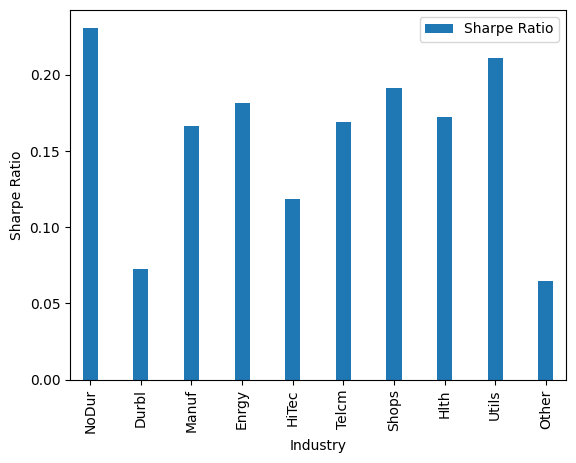

In [123]:
plt.figure(dpi=300,figsize=[16,10])
Sharpe.plot(kind = 'bar',xlabel = 'Industry',ylabel = 'Sharpe Ratio',width=0.3)
plt.show()

<Figure size 4800x3000 with 0 Axes>

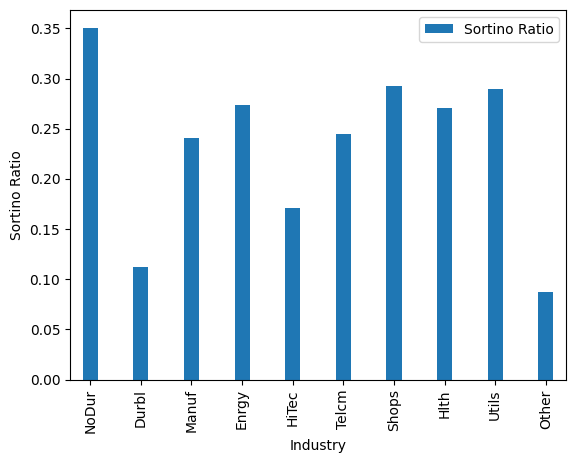

In [124]:
plt.figure(dpi=300,figsize=[16,10])
Sortino.plot(kind = 'bar',xlabel = 'Industry',ylabel = 'Sortino Ratio',width=0.3)
plt.show()

<Figure size 4800x3000 with 0 Axes>

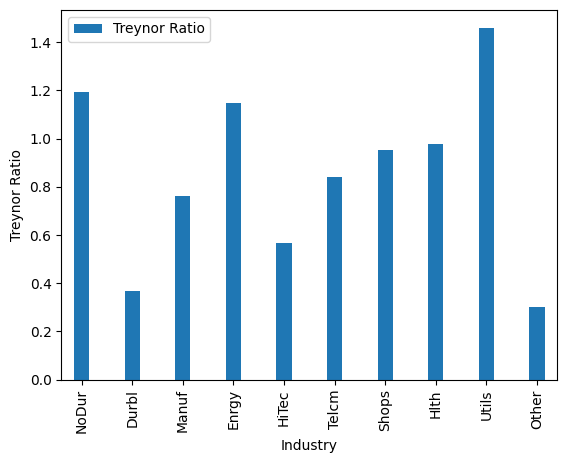

In [125]:
plt.figure(dpi=300,figsize=[16,10])
Treynor.plot(kind = 'bar',xlabel = 'Industry',ylabel = 'Treynor Ratio',width=0.3)
plt.show()

<Figure size 4800x3000 with 0 Axes>

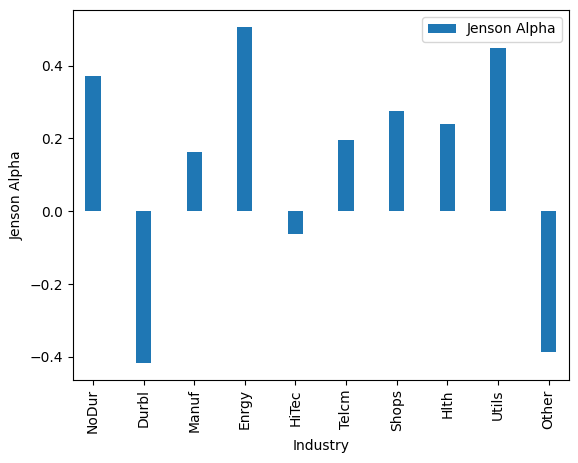

In [126]:
plt.figure(dpi=300,figsize=[16,10])
Jenson.plot(kind = 'bar',xlabel = 'Industry',ylabel = 'Jenson Alpha',width=0.3)
plt.show()

In [127]:
FFM = FFM.drop(['Beta','Gamma','Delta'],axis=1)

<Figure size 4800x3000 with 0 Axes>

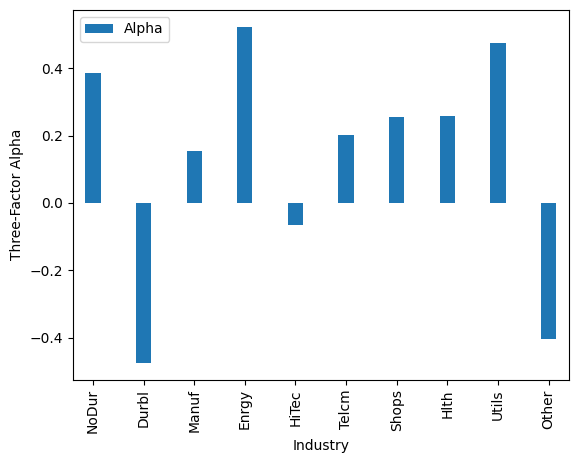

In [128]:
plt.figure(dpi=300,figsize=[16,10])
FFM.plot(kind = 'bar',xlabel = 'Industry',ylabel = 'Three-Factor Alpha',width=0.3)
plt.legend(loc='upper left')
plt.show()

#### The economic significance of each of the three performance ratios

1. Sharpe Ratio - Sharpe provides measure of investment's performace adjusted for the amount of risk taken. Sharpe can be used for making investment decisions such as higher Sharpe indicated better risk-adjusted performance. It can be used for risk management, capital allocation or benchmarking. It is designed to capture total risk, both systematic and idiosyncratic risk hence not useful for comparing performance of individual investment to diversified portfolio




2. Treynor Ratio - It similar to Sharpe ratio but Treynor ratio considers systematic risk factor as against standard deviation in Sharpe ratio. Hence Treynor can be used to compare performance of individual investment to diversified portfolio. 




3. Sortino Ratio - Unlike the Sharpe Ratio, which considers all types of volatility, the Sortino Ratio focuses specifically on downside risk hence it relevant for risk-averse investors who are more concerned about avoiding losses. A higher Sortino Ratio indicates that the investment is providing a higher return relative to the level of downside risk taken.